In [1]:
import tomotopy as tp
import numpy as np
import pandas as pd
import re
import os
import time
import itertools
import konlpy
from kiwipiepy import Kiwi
from hanspell import spell_checker
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyLDAvis


In [2]:
df=pd.read_csv('plus.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_title  3285 non-null   object 
 1   review        3285 non-null   object 
 2   score         3285 non-null   object 
 3   real_date     3285 non-null   object 
 4   year          3285 non-null   float64
 5   month         3285 non-null   float64
 6   type          2969 non-null   object 
 7   dataset       3219 non-null   object 
dtypes: float64(2), object(6)
memory usage: 205.4+ KB


C:\Users\jenny\AppData\Local\Temp/ipykernel_30868/811265187.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df=pd.read_csv('plus.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})


In [3]:
df[df['dataset'].isnull()]

,review_title,review,score,real_date,year,month,type,dataset
4,"코레일 패스를 구입하지 않는, 거대한 돈 낭비!","돈에 대해 주의하지 않으면, 사 코레일 전달할 수 있습니다. 하지만 이 거대한 돈 ...",1,2015년 6월,2015.0,6.0,커플,NaN
26,부드러운 ktx 여행,부산 ktx가 하루를 계획하기 로 결정하고 2시간 40분 걸리는 소용돌이 가 서울역...,5,2016년 4월,2016.0,4.0,친구,NaN
54,빠른 장거리 교통수단!,"2004년 4월 세계 5번째로 개통된 고속철도로, 특히 종전의 고속철도 보유국들이 ...",4,2016년 11월,2016.0,11.0,개인,NaN
74,서울에서 부산 가기 쉽게,가격이 저렴하고 더 나은 서울과 부산 간 항공 ktx 를 타 보다. 라운드 - 항공...,3,2017년 6월,2017.0,6.0,NaN,NaN
76,나쁘지 않음!,"일반적으로, 이 효과적으로 대중 교통. 주요 도시 에 sk 연결됩니다. 많은 현지 ...",4,2017년 7월,2017.0,7.0,가족,NaN
...,...,...,...,...,...,...,...,...
2902,편안하게. 신뢰할 수 있는. 저렴한 가격,나는 서울에 있는 메트로 역에 6월 2017. 명동 / 동대문 시장으로 가는 길에 ...,5,2017년 6월,2017.0,6.0,친구,NaN
2925,부품은 좋으나 혼란,매우 저렴한 지하철 시스템은 사용할 수 있습니다. 저는 천안에 덕종 기차역 근처. ...,4,2017년 6월,2017.0,6.0,개인,NaN
2998,주변에 좋은 방법을 서울에서,"지하철은 빠르고 편리하게 합니다. 그러나, 이 소식은 곳. 우리는 지하철을 타고 우...",5,2017년 7월,2017.0,7.0,가족,NaN
3186,성수동 맛집묵수육한판세트 옛날김치찝,이제 곧 노출에 계절이 다 되어서 반팔입고 몸에 붙는 옷 입고 다녀야 하는데 복부에...,5,2018년 11월,2018.0,11.0,친구,NaN


In [4]:
#결측치 데이터 지우기
df.dropna(subset=['dataset'], how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3219 entries, 0 to 3284
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_title  3219 non-null   object 
 1   review        3219 non-null   object 
 2   score         3219 non-null   object 
 3   real_date     3219 non-null   object 
 4   year          3219 non-null   float64
 5   month         3219 non-null   float64
 6   type          2906 non-null   object 
 7   dataset       3219 non-null   object 
dtypes: float64(2), object(6)
memory usage: 226.3+ KB


In [5]:
import konlpy
stop_list=['우리','함께','있습니다']
def tokenize_korean_text(text):
    text = re.sub(r'[^,.?!\w\s]','', text)
    
    okt = konlpy.tag.Okt()
    Okt_morphs = okt.pos(text)
    
    words = []
    for word, pos in Okt_morphs:
        if not pos == 'Josa' and not pos =='Punctuation' and not pos =='Foreign' and len(word) > 1 and word not in stop_list :
            words.append(word)
    ## word를 이어붙인 string 형태가 아닌 word의 list를 return해주는 게 sklearn lda 준비 과정과의 차이
            
    return words

In [6]:
tokenized_list2 = []
a=df['dataset'].values
for text in range(len(a)):
    tokenized_list2.append(tokenize_korean_text(a[text]))

In [7]:
model = tp.DMRModel(k=20, alpha=0.1, eta=0.01, min_cf=3,rm_top=3,tw=tp.TermWeight.IDF)

key=df['score'].values
value=tokenized_list2


for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass
        
               
model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 

Total docs: 3219
Total words: 79890
Vocab size: 2837


==== Coherence : c ====
Average: 0.48390083102654896 
Per Topic: [0.44115339666604997, 0.4641020350158215, 0.5266196429729462, 0.48547545336186887, 0.5658300429582596, 0.43100203527137637, 0.5701010897755623, 0.4253798805002589, 0.4913834691047668, 0.44802061188966036, 0.5248245507478714, 0.4702288918197155, 0.46285732011310754, 0.4626015327870846, 0.4552913412451744, 0.48759677559137343, 0.4527824971824884, 0.566836154460907, 0.48981319144368174, 0.45611670762300494]


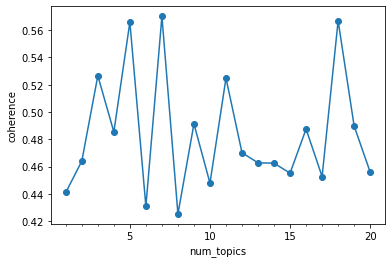

In [8]:
# calculate coherence using preset
ax=plt.axes()
coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]
print('==== Coherence : c ====')
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
x=range(1,21,1)
plt.plot(x, coherence_per_topic,marker='o')
plt.xlabel("num_topics")
plt.ylabel("coherence")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()
print()

위 결과에서 14개일 때 가장 높은 응집도를 보였기 때문에 토픽을 14개로 설정하였다.

In [9]:
model = tp.DMRModel(k=5 , alpha=0.1, eta=0.01, min_df=3,rm_top=3,tw=tp.TermWeight.IDF)

key=df['score'].values
value=tokenized_list2


for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass

model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 
 
 
for i in range(200):
    model.train(1)
    
for i in range(model.k):
    res = model.get_topic_words(i, top_n=10)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))

Total docs: 3219
Total words: 79722
Vocab size: 2782
Topic #0	이용, 환승, 호선, 수단, 최고, 출퇴근, 나라, 교통, 시간, 세계
Topic #1	거리, 홍콩, 있어, 하게, 다른, 서로, 아침, 위치, 매일, 경험
Topic #2	카드, 사용, 티켓, 영어, 여행, 시스템, 쉽게, 방법, 모든, 좋은
Topic #3	인터넷, 와이파이, 무선, 세계, 손쉬운, 통한, 무료, 된다, 게다가, 시간
Topic #4	기차, 매우, 깨끗하고, 쉽게, 시간, 아주, 사용, 여행, 사람, 좋은


In [10]:
model.summary()

<Basic Info>
| DMRModel (current version: 0.12.2)
| 3219 docs, 79722 words
| Total Vocabs: 8276, Used Vocabs: 2782
| Entropy of words: 6.60622
| Entropy of term-weighted words: 7.24001
| Removed Vocabs: 지하철 서울 있는
| Metadata of docs and its distribution
|  5: 2095
|  3: 205
|  4: 888
|  2: 20
|  1: 11
|
<Training Info>
| Iterations: 200, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.26014
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 0 (minimum collection frequency of words)
| min_df: 3 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 5 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (an initial value of exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic - word)
| sigma: 1.0 (standard deviation of normal d

In [11]:
#감성점수 계산
print('Topic distributions by score')

df2=pd.DataFrame()
score_labels=['1','2','3','4','5']
for i in score_labels:
    df2[i+'score']=model.get_topic_prior(i)
df2['total']=df2.sum(axis=1)

total_sum=df2['total'].values
gamsung_sum=0
gamsung_list=[]
for i in range(model.k):
    a=df2.iloc[i,:-1].values
    gamsung_sum=(a[0]*1+a[1]*2+a[2]*3+a[3]*4+a[4]*5)/total_sum[i]
    gamsung_list.append(gamsung_sum)
    
df2['re_score']=gamsung_list
df2=df2.round(3)
df2.head(20)

Topic distributions by score


,1score,2score,3score,4score,5score,total,re_score
0,0.046,0.032,0.961,0.133,0.167,1.338,3.256
1,0.113,0.033,0.041,0.038,0.018,0.243,2.236
2,0.044,0.115,0.015,0.149,0.058,0.380,3.160
3,0.268,0.019,0.014,0.015,0.013,0.329,1.432
4,0.022,0.171,0.080,0.181,0.309,0.762,3.765


In [12]:
#각 토픽 별 상위 10개 단어 추출
word_list=[]
for i in range(model.k):
    a=model.get_topic_words(i, top_n=10)
    word_list.append([x[0] for x in a])

df2['word_list']=word_list
df2.head(15)

,1score,2score,3score,4score,5score,total,re_score,word_list
0,0.046,0.032,0.961,0.133,0.167,1.338,3.256,"[이용, 환승, 호선, 수단, 최고, 출퇴근, 나라, 교통, 시간, 세계]"
1,0.113,0.033,0.041,0.038,0.018,0.243,2.236,"[거리, 홍콩, 있어, 하게, 다른, 서로, 아침, 위치, 매일, 경험]"
2,0.044,0.115,0.015,0.149,0.058,0.380,3.160,"[카드, 사용, 티켓, 영어, 여행, 시스템, 쉽게, 방법, 모든, 좋은]"
3,0.268,0.019,0.014,0.015,0.013,0.329,1.432,"[인터넷, 와이파이, 무선, 세계, 손쉬운, 통한, 무료, 된다, 게다가, 시간]"
4,0.022,0.171,0.080,0.181,0.309,0.762,3.765,"[기차, 매우, 깨끗하고, 쉽게, 시간, 아주, 사용, 여행, 사람, 좋은]"


In [15]:
 # extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=5, min_df=5, max_len=5, max_cand=10000, normalized=True)
cands = extractor.extract(model)

labeler = tp.label.FoRelevance(model, cands, min_df=5, smoothing=1e-2, mu=0.25)
for k in range(model.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in model.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

== Topic #0 ==
Labels: 환승, 출퇴근, 호선, 출퇴근 시간, 이용
이용	0.011963197961449623
환승	0.011603136546909809
호선	0.011396217159926891
수단	0.008775677531957626
최고	0.008695876225829124
출퇴근	0.008549535647034645
나라	0.007885771803557873
교통	0.007598048076033592
시간	0.007408649194985628
세계	0.007106036879122257

== Topic #1 ==
Labels: 연습, 상당한, 있는, 나중, 서로
거리	0.013160855509340763
홍콩	0.010286032222211361
있어	0.009898360818624496
하게	0.009443562477827072
다른	0.00930703990161419
서로	0.008999718353152275
아침	0.008733962662518024
위치	0.008421347476541996
매일	0.008391030132770538
경험	0.0076004331931471825

== Topic #2 ==
Labels: 티켓, 카드, 또는, 경우, 영어
카드	0.01048901118338108
사용	0.009176996536552906
티켓	0.00883877370506525
영어	0.007475391495972872
여행	0.006991574540734291
시스템	0.0068045021034777164
쉽게	0.006509663537144661
방법	0.006175421644002199
모든	0.006135180126875639
좋은	0.005953454412519932

== Topic #3 ==
Labels: 청결한, 설치 되어, 시스템 생각, 냉방, 여름 시원하고
인터넷	0.01869218796491623
와이파이	0.017010405659675598
무선	0.013446159660816193
세계	0.0125113548

In [16]:
df3=pd.DataFrame()
df3['docs']=tokenized_list2
df3['score']=df['score'].values
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3219 entries, 0 to 3218
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   docs    3219 non-null   object
 1   score   3219 non-null   object
dtypes: object(2)
memory usage: 50.4+ KB


In [17]:
#빈도 구하기

topic_num=[]
temp1=[] #토픽번호
temp2=[] #분포율
for i in range(len(model.docs)):
    a=model.docs[i].get_topics()
    temp1.append([x[0] for x in a])
    temp2.append([x[1] for x in a])
for i in range(len(temp1)):
    if temp2[i][0] >= 0.5:
        topic_num.append(temp1[i][0])
    else :
        topic_num.append(np.NaN)

In [18]:
df3['topic_num']=topic_num
df3[df3['topic_num'].isnull()]

,docs,score,topic_num
6,"[시간, 빠른, 깨끗하고, 무료, 와이파이, 예약, 3일, 코레일, 패스, 가공, ...",5,NaN
10,"[여행, 하기, 좋은, 서울, ktx, 이용, 하여, 대구, 비행, 베이징, 2시간...",4,NaN
19,"[퍼스트, 클래스, 티켓, 미리, 예약, 여자친구, 다시, 서울, 부산, 형태, 외...",2,NaN
40,"[열차, 시트, 리그, 시트, 리그, 서울, 부산, ktx, 사랑, 열차, 와우, ...",5,NaN
54,"[쉬운, 여행, 효율, 교육, 무료, 무선, 인터넷, 내장, 필요한, 주는, 신용,...",4,NaN
...,...,...,...
3171,"[편리하고, 저렴한, 서울, 메트로, 평소, 매일, 이용, 하지만, 지방, 초등학생...",5,NaN
3204,"[서울, 지하철, 완전히, 편리합니다, 서울, 지하철, 매우, 편리합니다, 역마, ...",5,NaN
3205,"[깨끗하고, 좋은, 메트로, 저렴하고, 깨끗하고, 이용, 편리합니다, 최근, 호선,...",5,NaN
3211,"[편안한, 호텔, 근처, 바로, 있어서, 찾기, 쉽고, 어딜, 가든, 교통, 편도,...",5,NaN


In [19]:
df4=df3.groupby(['topic_num','score'])['docs']
print(df4.size().reset_index(name='counts'))

    topic_num score  counts
0         0.0     1       4
1         0.0     2       3
2         0.0     3      89
3         0.0     4     258
4         0.0     5     507
5         1.0     4       6
6         1.0     5       8
7         2.0     1       3
8         2.0     2       7
9         2.0     3      43
10        2.0     4     285
11        2.0     5     644
12        3.0     4       2
13        3.0     5       9
14        4.0     1       3
15        4.0     2       5
16        4.0     3      54
17        4.0     4     259
18        4.0     5     745
